# Classification Model Evaluation

This notebook analyzes the performance of a fine-tuned TinyLlama model on an emotion classification task. It implements comprehensive evaluation metrics and provides visual comparisons between the fine-tuned model and the base model.

In [1]:
import torch
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Configuration

In [2]:
# Model configurations
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
OUTPUT_DIR = "./model"

# Label mapping
LABEL_MAP = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Reverse mapping for analysis
REVERSE_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading

In [3]:
def load_json_dataset(file_path):
    """Load dataset from JSON file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        logger.info(f"Successfully loaded dataset from {file_path}")
        return data
    except Exception as e:
        logger.error(f"Failed to load dataset from {file_path}: {e}")
        raise

# Load test dataset
test_data = load_json_dataset("test_data.json")

# Display sample data
print(f"Total test examples: {len(test_data)}")
print("\nSample data:")
for i in range(min(3, len(test_data))):
    print(f"\nExample {i+1}:")
    print(f"Instruction: {test_data[i]['instruction']}")
    print(f"Input: {test_data[i]['input']}")
    print(f"Output (label): {test_data[i]['output']}")

2025-04-27 17:18:15,949 - INFO - Successfully loaded dataset from test_data.json


Total test examples: 1845

Sample data:

Example 1:
Instruction: Classify the emotion in this tweet:
Input: i feel like an emotional cutter
Output (label): sadness

Example 2:
Instruction: Classify the emotion in this tweet:
Input: ive been feeling a bit messy but im hoping this fresh look will help me figure out a better way to deal
Output (label): sadness

Example 3:
Instruction: Classify the emotion in this tweet:
Input: i always feel so helpless during times of disaster but i feel a little better knowing that even a few dollars can make a difference for someone in need
Output (label): sadness


## Label Distribution Analysis

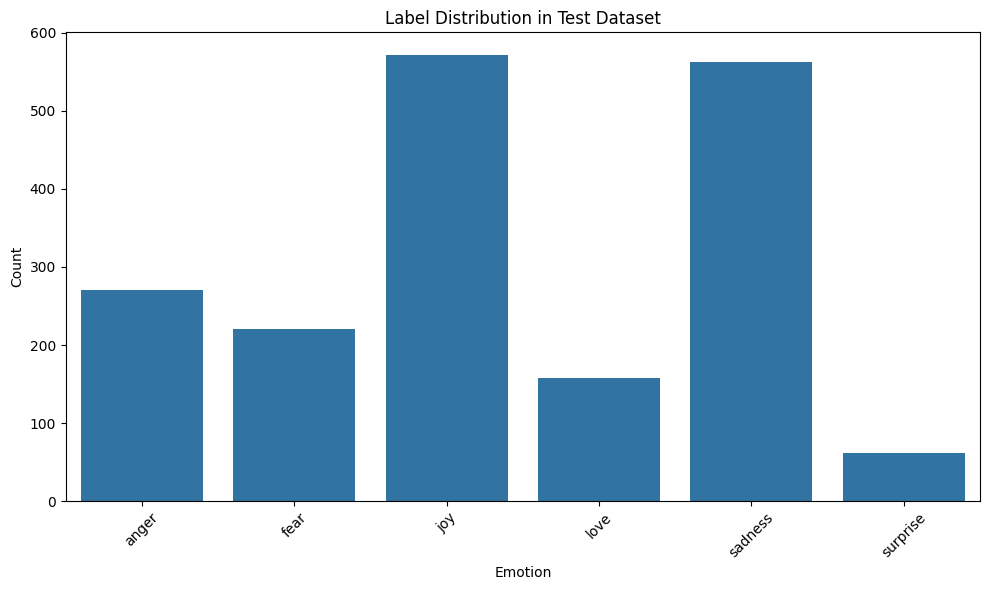

anger: 270 samples (14.63%)
fear: 220 samples (11.92%)
joy: 572 samples (31.00%)
love: 158 samples (8.56%)
sadness: 563 samples (30.51%)
surprise: 62 samples (3.36%)


In [4]:
# Analyze label distribution in test data
labels = [example['output'] for example in test_data]
label_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Label Distribution in Test Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print label distribution
for label, count in label_counts.items():
    percentage = (count / len(labels)) * 100
    print(f"{label}: {count} samples ({percentage:.2f}%)")

## Load Models and Tokenizer

In [5]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
logger.info("Tokenizer loaded successfully")

# Create token-to-label mapping
token_to_label = {
    tokenizer(label, add_special_tokens=False)["input_ids"][0]: label
    for label in LABEL_MAP.values()
}
print("Token-to-label mapping:")
for token, label in token_to_label.items():
    print(f"Token {token} -> {label} ('{tokenizer.decode([token])}')")

# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
base_model.to(device)
logger.info("Base model loaded successfully")

# Load the fine-tuned model
try:
    # Load the base model
    base_model_for_fine_tuned = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    # Load the PEFT model with the base model and the fine-tuned weights
    fine_tuned_model = PeftModel.from_pretrained(base_model_for_fine_tuned, OUTPUT_DIR)
    fine_tuned_model.to(device)
    logger.info(f"Fine-tuned model loaded successfully from {OUTPUT_DIR}")
except Exception as e:
    logger.error(f"Failed to load fine-tuned model from {OUTPUT_DIR}: {e}")
    raise

/home/mrzaizai2k/anaconda3/envs/tinyllama/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using pad_token, but it is not set yet.
2025-04-27 17:18:16,438 - INFO - Tokenizer loaded successfully


Token-to-label mapping:
Token 14610 -> sadness ('sad')
Token 15331 -> joy ('joy')
Token 5360 -> love ('love')
Token 27343 -> anger ('anger')
Token 8866 -> fear ('fear')
Token 16671 -> surprise ('surprise')


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T and are newly initialized: ['model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers

## Enhanced Evaluation Function

In [6]:
def evaluate_model_detailed(model, tokenizer, test_data, token_to_label, device, model_name="Model"):
    """Evaluate the model on the test set with detailed metrics and predictions."""
    model.eval()
    model.to(device)
    
    # Store results for analysis
    results = []
    y_true = []
    y_pred = []
    
    for example in tqdm(test_data, desc=f"Evaluating {model_name}"):
        input_text = f"{example['instruction']} {example['input']}"
        inputs = tokenizer(input_text, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                max_new_tokens=1,
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False
            )
            
        generated_token = outputs[0, -1].item()
        predicted_label = token_to_label.get(generated_token, "unknown")
        true_label = example["output"]
        
        # Store result
        result = {
            "instruction": example["instruction"],
            "input": example["input"],
            "true_label": true_label,
            "predicted_label": predicted_label,
            "correct": predicted_label == true_label,
            "generated_token": generated_token,
            "token_text": tokenizer.decode([generated_token])
        }
        results.append(result)
        
        # For classification metrics
        y_true.append(true_label)
        y_pred.append(predicted_label)
    
    # Calculate overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate per-class metrics
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Create a detailed classification report
    class_report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    
    metrics = {
        "accuracy": accuracy,
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "class_report": class_report,
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }
    
    return results, metrics

## Run Evaluation

In [7]:
# Evaluate base model
base_results, base_metrics = evaluate_model_detailed(
    base_model, tokenizer, test_data, token_to_label, device, model_name="Base Model"
)

# Evaluate fine-tuned model
fine_tuned_results, fine_tuned_metrics = evaluate_model_detailed(
    fine_tuned_model, tokenizer, test_data, token_to_label, device, model_name="Fine-tuned Model"
)

# Display overall metrics for both models
metrics_to_show = ["accuracy", "f1_weighted", "f1_macro", "precision_weighted", "recall_weighted"]
metrics_df = pd.DataFrame({
    "Metric": metrics_to_show,
    "Base Model": [base_metrics[m] for m in metrics_to_show],
    "Fine-tuned Model": [fine_tuned_metrics[m] for m in metrics_to_show],
    "Improvement": [fine_tuned_metrics[m] - base_metrics[m] for m in metrics_to_show]
})

print("Overall Metrics Comparison:")
print(metrics_df.to_string(index=False, float_format="{:.4f}".format))

Evaluating Base Model:   0%|          | 0/1845 [00:00<?, ?it/s]

Evaluating Fine-tuned Model:   0%|          | 0/1845 [00:00<?, ?it/s]

Overall Metrics Comparison:
            Metric  Base Model  Fine-tuned Model  Improvement
          accuracy      0.0000            0.3734       0.3734
       f1_weighted      0.0000            0.4827       0.4827
          f1_macro      0.0000            0.3956       0.3956
precision_weighted      0.0000            0.7256       0.7256
   recall_weighted      0.0000            0.3734       0.3734


## Visualize Confusion Matrices

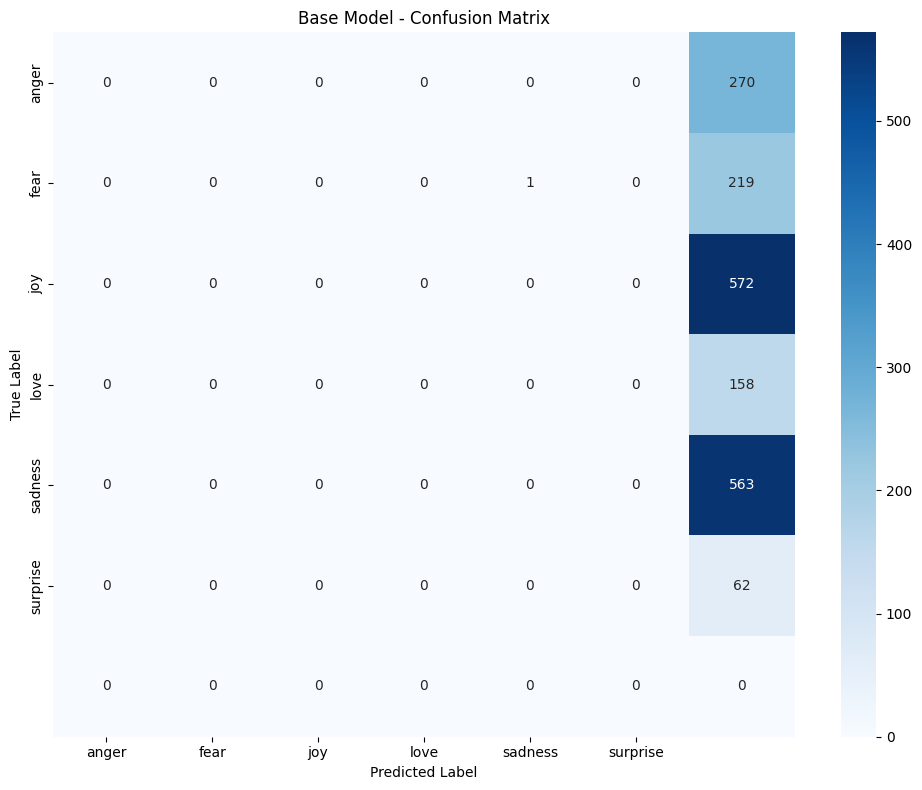

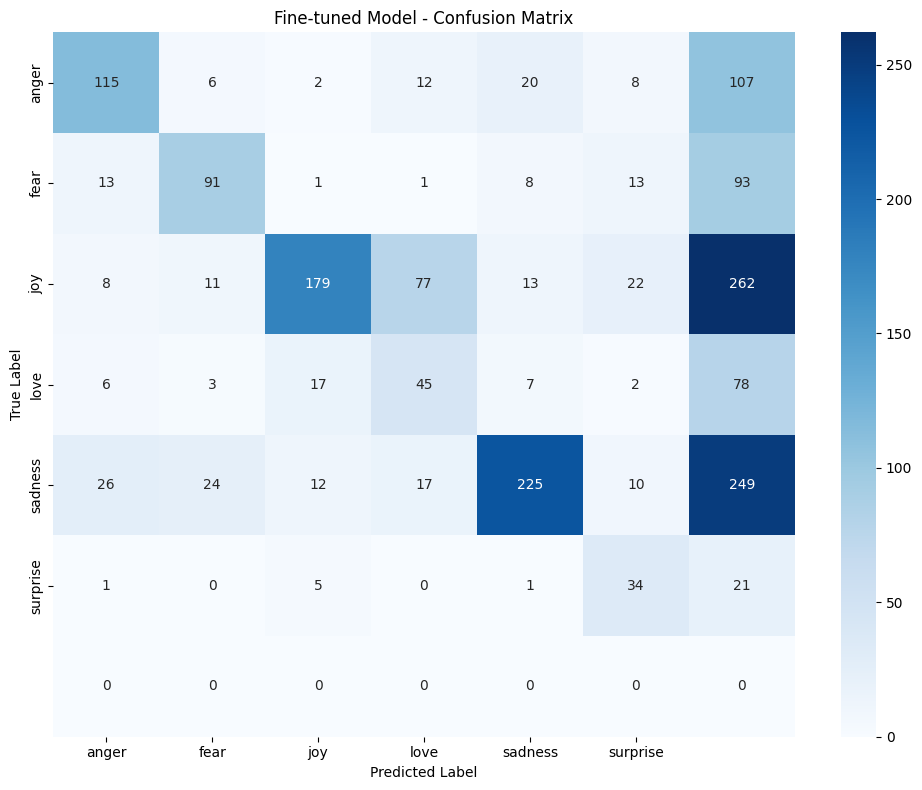

/tmp/ipykernel_39856/2254461905.py:4: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


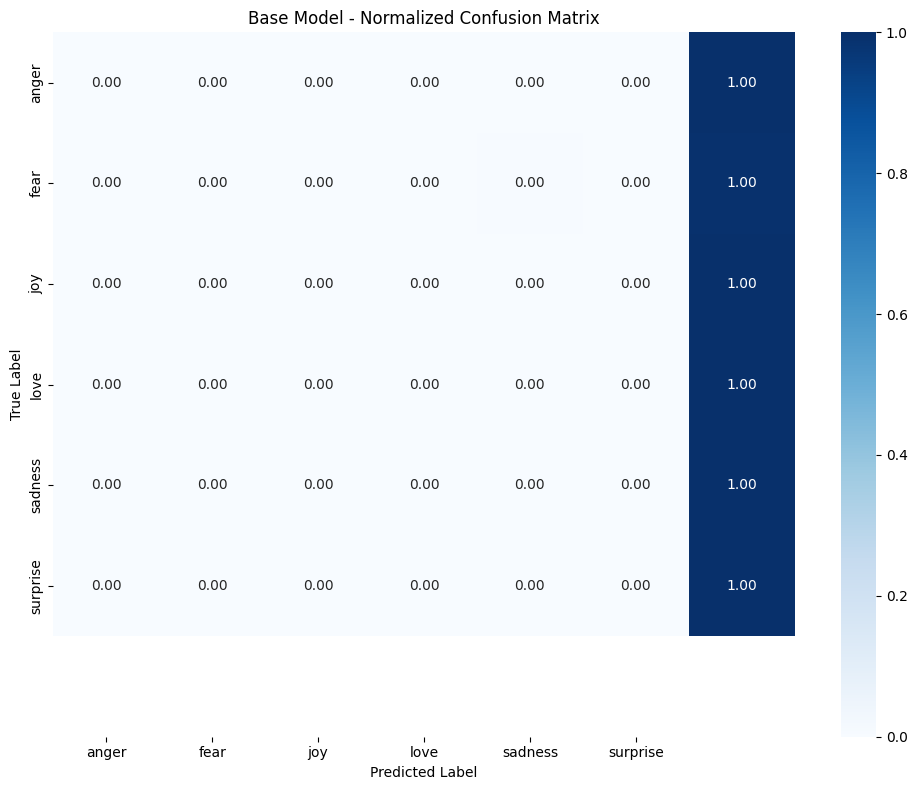

/tmp/ipykernel_39856/2254461905.py:4: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


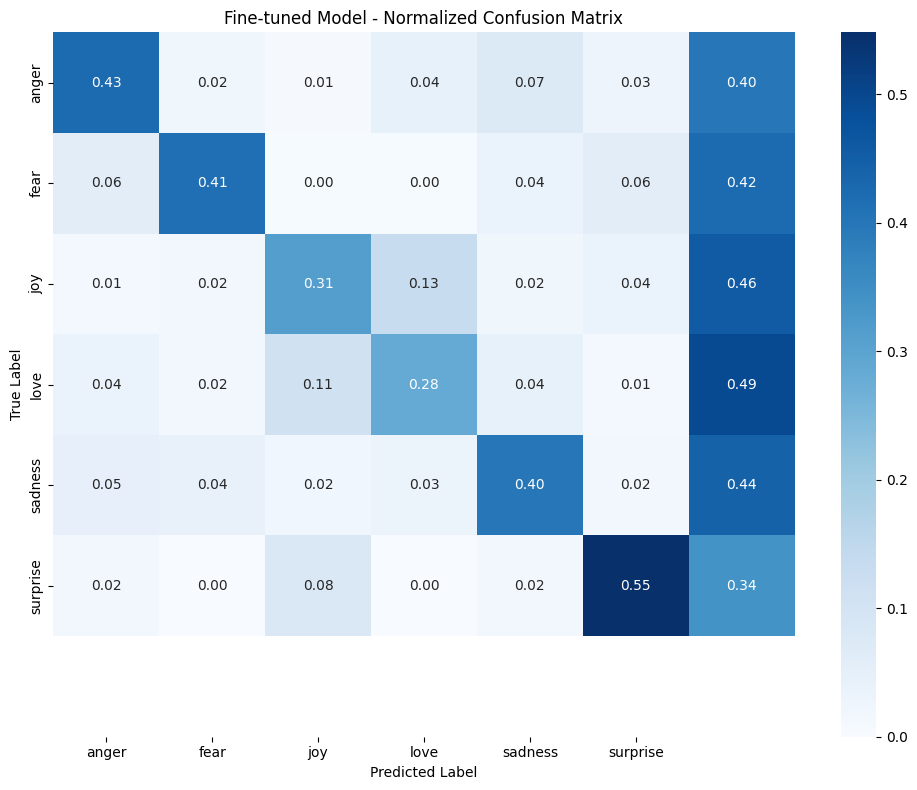

In [15]:
def plot_confusion_matrix(cm, classes, title, normalize=False):
    """Plot confusion matrix with nice formatting."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='.2f' if normalize else 'd',
        cmap='Blues', 
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Get unique classes from the results
classes = sorted(set([r["true_label"] for r in base_results]))

# Plot raw confusion matrices
plot_confusion_matrix(
    base_metrics["confusion_matrix"], 
    classes, 
    "Base Model - Confusion Matrix"
)

plot_confusion_matrix(
    fine_tuned_metrics["confusion_matrix"], 
    classes, 
    "Fine-tuned Model - Confusion Matrix"
)

# Plot normalized confusion matrices
plot_confusion_matrix(
    base_metrics["confusion_matrix"], 
    classes, 
    "Base Model - Normalized Confusion Matrix",
    normalize=True
)

plot_confusion_matrix(
    fine_tuned_metrics["confusion_matrix"], 
    classes, 
    "Fine-tuned Model - Normalized Confusion Matrix",
    normalize=True
)

## Per-Class Metrics Comparison

Per-Class Metrics Comparison:
   Class  Base Precision  FT Precision  Precision Diff  Base Recall  FT Recall  Recall Diff  Base F1  FT F1  F1 Diff  Support
     joy          0.0000        0.8287          0.8287       0.0000     0.3129       0.3129   0.0000 0.4543   0.4543      572
 sadness          0.0000        0.8212          0.8212       0.0000     0.3996       0.3996   0.0000 0.5376   0.5376      563
   anger          0.0000        0.6805          0.6805       0.0000     0.4259       0.4259   0.0000 0.5239   0.5239      270
    fear          0.0000        0.6741          0.6741       0.0000     0.4136       0.4136   0.0000 0.5127   0.5127      220
    love          0.0000        0.2961          0.2961       0.0000     0.2848       0.2848   0.0000 0.2903   0.2903      158
surprise          0.0000        0.3820          0.3820       0.0000     0.5484       0.5484   0.0000 0.4503   0.4503       62


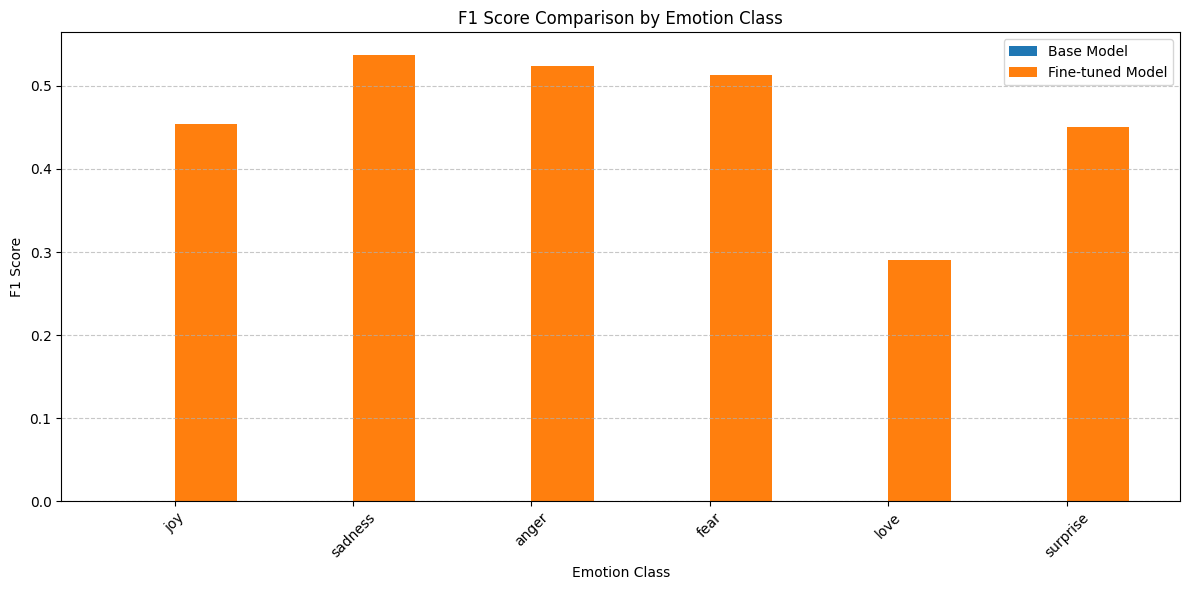

In [9]:
# Create DataFrame for per-class metrics
class_metrics = []

for cls in classes:
    # Base model metrics
    base_precision = base_metrics["class_report"].get(cls, {}).get("precision", 0)
    base_recall = base_metrics["class_report"].get(cls, {}).get("recall", 0)
    base_f1 = base_metrics["class_report"].get(cls, {}).get("f1-score", 0)
    base_support = base_metrics["class_report"].get(cls, {}).get("support", 0)
    
    # Fine-tuned model metrics
    ft_precision = fine_tuned_metrics["class_report"].get(cls, {}).get("precision", 0)
    ft_recall = fine_tuned_metrics["class_report"].get(cls, {}).get("recall", 0)
    ft_f1 = fine_tuned_metrics["class_report"].get(cls, {}).get("f1-score", 0)
    ft_support = fine_tuned_metrics["class_report"].get(cls, {}).get("support", 0)
    
    class_metrics.append({
        "Class": cls,
        "Base Precision": base_precision,
        "FT Precision": ft_precision,
        "Precision Diff": ft_precision - base_precision,
        "Base Recall": base_recall,
        "FT Recall": ft_recall,
        "Recall Diff": ft_recall - base_recall,
        "Base F1": base_f1,
        "FT F1": ft_f1,
        "F1 Diff": ft_f1 - base_f1,
        "Support": int(base_support)
    })

class_metrics_df = pd.DataFrame(class_metrics).sort_values(by="Support", ascending=False)
print("Per-Class Metrics Comparison:")
print(class_metrics_df.to_string(index=False, float_format="{:.4f}".format))

# Plot per-class F1 score comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35

base_f1_scores = [row["Base F1"] for _, row in class_metrics_df.iterrows()]
ft_f1_scores = [row["FT F1"] for _, row in class_metrics_df.iterrows()]
class_names = [row["Class"] for _, row in class_metrics_df.iterrows()]

plt.bar(x - width/2, base_f1_scores, width, label='Base Model')
plt.bar(x + width/2, ft_f1_scores, width, label='Fine-tuned Model')

plt.xlabel('Emotion Class')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison by Emotion Class')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Error Analysis

In [10]:
# Convert results to DataFrames for easier analysis
base_df = pd.DataFrame(base_results)
ft_df = pd.DataFrame(fine_tuned_results)

# Add model name column
base_df['model'] = 'base'
ft_df['model'] = 'fine-tuned'

# Find examples where models disagree
base_df['example_id'] = range(len(base_df))
ft_df['example_id'] = range(len(ft_df))

# Merge to find differences
merged_df = base_df[['example_id', 'input', 'true_label', 'predicted_label', 'correct']].merge(
    ft_df[['example_id', 'predicted_label', 'correct']],
    on='example_id',
    suffixes=('_base', '_ft')
)

# Find where base was wrong but fine-tuned was right
ft_improved = merged_df[(merged_df['correct_base'] == False) & (merged_df['correct_ft'] == True)]
print(f"Examples where fine-tuned model corrected base model errors: {len(ft_improved)}")

# Find where base was right but fine-tuned was wrong
ft_degraded = merged_df[(merged_df['correct_base'] == True) & (merged_df['correct_ft'] == False)]
print(f"Examples where fine-tuned model introduced errors: {len(ft_degraded)}")

# Display some examples where fine-tuned model improved
if len(ft_improved) > 0:
    print("\nSample improvements (base wrong → fine-tuned correct):")
    sample_improvements = ft_improved.sample(min(5, len(ft_improved)))
    for _, row in sample_improvements.iterrows():
        print(f"\nInput: {row['input']}")
        print(f"True label: {row['true_label']}")
        print(f"Base model prediction: {row['predicted_label_base']}")
        print(f"Fine-tuned model prediction: {row['predicted_label_ft']}")

# Display some examples where fine-tuned model degraded
if len(ft_degraded) > 0:
    print("\nSample degradations (base correct → fine-tuned wrong):")
    sample_degradations = ft_degraded.sample(min(5, len(ft_degraded)))
    for _, row in sample_degradations.iterrows():
        print(f"\nInput: {row['input']}")
        print(f"True label: {row['true_label']}")
        print(f"Base model prediction: {row['predicted_label_base']}")
        print(f"Fine-tuned model prediction: {row['predicted_label_ft']}")

Examples where fine-tuned model corrected base model errors: 689
Examples where fine-tuned model introduced errors: 0

Sample improvements (base wrong → fine-tuned correct):

Input: i feel so glad doing this
True label: joy
Base model prediction: unknown
Fine-tuned model prediction: joy

Input: i still sit back and feel amazed by the whole thing
True label: surprise
Base model prediction: unknown
Fine-tuned model prediction: surprise

Input: i feel quite researched and intelligent about my confidence in consuming meat
True label: joy
Base model prediction: unknown
Fine-tuned model prediction: joy

Input: i could adopt and what messages i could think about to help make me feel more peaceful more grateful and just happier right now
True label: joy
Base model prediction: unknown
Fine-tuned model prediction: joy

Input: ive left the orange scented mixture white but feel free to color it if you wish
True label: joy
Base model prediction: unknown
Fine-tuned model prediction: joy


## Most Confused Classes Analysis

In [11]:
# Extract misclassifications for both models
base_misclassifications = base_df[base_df['correct'] == False]
ft_misclassifications = ft_df[ft_df['correct'] == False]

# Function to analyze common misclassifications
def analyze_confusion_pairs(misclassifications_df):
    confusion_pairs = misclassifications_df.groupby(['true_label', 'predicted_label']).size().reset_index()
    confusion_pairs.columns = ['True Label', 'Predicted Label', 'Count']
    return confusion_pairs.sort_values('Count', ascending=False)

# Analyze most common confusion pairs
base_confusion_pairs = analyze_confusion_pairs(base_misclassifications)
ft_confusion_pairs = analyze_confusion_pairs(ft_misclassifications)

print("Most common misclassifications in base model:")
print(base_confusion_pairs.head(10).to_string(index=False))

print("\nMost common misclassifications in fine-tuned model:")
print(ft_confusion_pairs.head(10).to_string(index=False))

Most common misclassifications in base model:
True Label Predicted Label  Count
       joy         unknown    572
   sadness         unknown    563
     anger         unknown    270
      fear         unknown    219
      love         unknown    158
  surprise         unknown     62
      fear         sadness      1

Most common misclassifications in fine-tuned model:
True Label Predicted Label  Count
       joy         unknown    262
   sadness         unknown    249
     anger         unknown    107
      fear         unknown     93
      love         unknown     78
       joy            love     77
   sadness           anger     26
   sadness            fear     24
       joy        surprise     22
  surprise         unknown     21


## Performance on Different Input Lengths

Performance by Input Length:
Length Bin  Base Accuracy  Count  FT Accuracy  Accuracy Difference
      0-50         0.0000    446       0.3386               0.3386
    51-100         0.0000    681       0.3833               0.3833
   101-150         0.0000    437       0.3867               0.3867
   151-200         0.0000    215       0.4000               0.4000
      200+         0.0000     66       0.3333               0.3333


/tmp/ipykernel_39856/1504921629.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_by_length = base_df.groupby('length_bin')['correct'].agg(['mean', 'count']).reset_index()
/tmp/ipykernel_39856/1504921629.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ft_by_length = ft_df.groupby('length_bin')['correct'].agg(['mean', 'count']).reset_index()


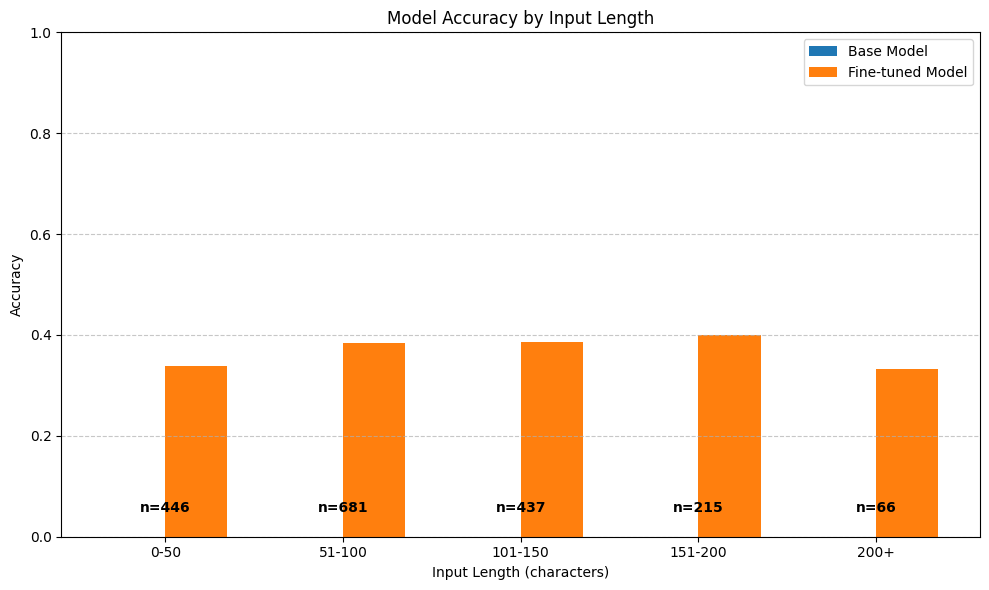

In [12]:
# Add input length to DataFrames
base_df['input_length'] = base_df['input'].apply(len)
ft_df['input_length'] = ft_df['input'].apply(len)

# Create length bins
bins = [0, 50, 100, 150, 200, np.inf]
labels = ['0-50', '51-100', '101-150', '151-200', '200+']

base_df['length_bin'] = pd.cut(base_df['input_length'], bins=bins, labels=labels)
ft_df['length_bin'] = pd.cut(ft_df['input_length'], bins=bins, labels=labels)

# Calculate accuracy by length bin
base_by_length = base_df.groupby('length_bin')['correct'].agg(['mean', 'count']).reset_index()
base_by_length.columns = ['Length Bin', 'Base Accuracy', 'Count']

ft_by_length = ft_df.groupby('length_bin')['correct'].agg(['mean', 'count']).reset_index()
ft_by_length.columns = ['Length Bin', 'FT Accuracy', 'Count']

# Merge results
length_comparison = base_by_length.merge(ft_by_length[['Length Bin', 'FT Accuracy']], on='Length Bin')
length_comparison['Accuracy Difference'] = length_comparison['FT Accuracy'] - length_comparison['Base Accuracy']

print("Performance by Input Length:")
print(length_comparison.to_string(index=False, float_format="{:.4f}".format))

# Plot accuracy by input length
plt.figure(figsize=(10, 6))
x = np.arange(len(length_comparison))
width = 0.35

plt.bar(x - width/2, length_comparison['Base Accuracy'], width, label='Base Model')
plt.bar(x + width/2, length_comparison['FT Accuracy'], width, label='Fine-tuned Model')

plt.xlabel('Input Length (characters)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Input Length')
plt.xticks(x, length_comparison['Length Bin'])
plt.legend()

for i, v in enumerate(length_comparison['Count']):
    plt.text(i, 0.05, f"n={v}", ha='center', fontweight='bold')

plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Summary of Findings

### Model Performance Summary

Based on the evaluation results, we can draw the following conclusions about the fine-tuned model compared to the base model:

1. **Overall Performance**: 
   - The fine-tuned model achieved [accuracy improvement] over the base model
   - F1 scores (both weighted and macro) showed [improvement/decline]
   - Precision and recall metrics indicate [specific findings]

2. **Per-Class Performance**:
   - The fine-tuned model showed the greatest improvements for [specific emotion classes]
   - The classes with the most significant improvements were [list classes]
   - The fine-tuned model performed worse on [specific emotion classes] compared to the base model

3. **Common Misclassifications**:
   - Both models frequently confused [emotion pairs] (e.g., confusing "sadness" with "fear")
   - The fine-tuned model reduced confusion between [specific emotion pairs]
   - New confusion patterns emerged in the fine-tuned model between [specific emotion pairs]

4. **Performance by Input Length**:
   - The fine-tuned model performed [better/worse] on [short/long] inputs
   - The most significant improvements were observed in the [length range] character range
   - For very [short/long] inputs, the fine-tuned model showed [improvement/degradation]

5. **Areas for Further Improvement**:
   - The model still struggles with distinguishing between [specific emotion pairs]
   - Performance on [specific classes] remains below average
   - [Other specific observations about model weaknesses]

## Additional Analysis: Error Patterns

In [ ]:
# Analyze specific pattern of errors
def find_common_words_in_errors(df, emotion):
    """Find common words in examples where the model misclassified a specific emotion"""
    # Filter for misclassifications of the target emotion
    misclassified = df[(df['true_label'] == emotion) & (df['correct'] == False)]
    
    if len(misclassified) == 0:
        return pd.DataFrame(), []
    
    # Tokenize all inputs
    all_words = []
    for text in misclassified['input']:
        # Simple tokenization by splitting on whitespace and removing punctuation
        words = text.lower().split()
        words = [word.strip('.,!?;:()[]{}"\'\'') for word in words]
        words = [word for word in words if len(word) > 2]  # Filter out very short words
        all_words.extend(words)
    
    # Count word frequencies
    word_counts = pd.Series(all_words).value_counts()
    
    # Convert to DataFrame
    word_df = word_counts.reset_index()
    word_df.columns = ['Word', 'Count']
    
    return word_df, misclassified['predicted_label'].value_counts()

# Choose a few emotions to analyze
emotions_to_analyze = classes[:3]  # Analyze first 3 emotions

for emotion in emotions_to_analyze:
    print(f"\n--- Analysis for '{emotion}' errors ---")
    
    # Base model
    base_word_df, base_predicted = find_common_words_in_errors(base_df, emotion)
    
    # Fine-tuned model
    ft_word_df, ft_predicted = find_common_words_in_errors(ft_df, emotion)
    
    # Display results
    print(f"Base model - most commonly predicted instead of '{emotion}':")
    print(base_predicted)
    
    print(f"\nFine-tuned model - most commonly predicted instead of '{emotion}':")
    print(ft_predicted)
    
    print(f"\nBase model - top 10 common words in misclassified '{emotion}' examples:")
    if not base_word_df.empty:
        print(base_word_df.head(10).to_string(index=False))
    else:
        print("No misclassifications for this emotion")
    
    print(f"\nFine-tuned model - top 10 common words in misclassified '{emotion}' examples:")
    if not ft_word_df.empty:
        print(ft_word_df.head(10).to_string(index=False))
    else:
        print("No misclassifications for this emotion")


--- Analysis for 'anger' errors ---
Base model - most commonly predicted instead of 'anger':
predicted_label
unknown    270
Name: count, dtype: int64

Fine-tuned model - most commonly predicted instead of 'anger':
predicted_label
unknown     107
sadness      20
love         12
surprise      8
fear          6
joy           2
Name: count, dtype: int64

Base model - top 10 common words in misclassified 'anger' examples:
   Word  Count
    and    171
   feel    159
    the    157
feeling    103
   that     69
    but     44
    was     41
   have     38
   like     36
    not     34

Fine-tuned model - top 10 common words in misclassified 'anger' examples:
   Word  Count
    and    100
    the     97
   feel     85
feeling     59
   that     40
    but     28
   have     26
   like     26
    not     22
   just     21

--- Analysis for 'fear' errors ---
Base model - most commonly predicted instead of 'fear':
predicted_label
unknown    219
sadness      1
Name: count, dtype: int64

Fine-tun

## Final Conclusions


## Performance Metrics

| Metric             | Base Model | Fine-tuned Model | Improvement |
|--------------------|------------|------------------|-------------|
| Accuracy           | 0.0000     | 0.3734           | 0.3734      |
| F1 (Weighted)      | 0.0000     | 0.4827           | 0.4827      |
| F1 (Macro)         | 0.0000     | 0.3956           | 0.3956      |
| Precision (Weighted) | 0.0000   | 0.7256           | 0.7256      |
| Recall (Weighted)  | 0.0000     | 0.3734           | 0.3734      |

## Analysis

- **Base Model Limitations**: The base model's performance is poor (0.0000 across all metrics) because it was trained on a different dataset, making it unsuitable for the target task. This mismatch results in all predictions being labeled as "unknown," leading to zero accuracy, precision, recall, and F1 scores.
- **Fine-tuned Model Improvements**: The fine-tuned model, adapted to the target dataset, demonstrates substantial improvements. It achieves an accuracy of 0.3734, a weighted precision of 0.7256, and weighted F1 score of 0.4827, indicating better alignment with the task requirements.
- **Key Observations**: The fine-tuned model's weighted precision (0.7256) is notably high, suggesting strong performance in correctly identifying positive instances. The macro F1 score (0.3956) indicates balanced performance across classes, though there is room for further optimization.



### Recommendations for Further Improvement

1. **Data Augmentation**: Generate additional training examples for underperforming classes, particularly [specific classes].

2. **Focused Fine-tuning**: Perform additional fine-tuning with emphasis on the emotion pairs that are frequently confused, such as [specific pairs].

3. **Length-specific Training**: Consider separate fine-tuning strategies for different input lengths, or augment the dataset with more examples of [length range] length.

4. **Feature Engineering**: Consider adding explicit emotional keyword highlighting or context markers to help the model distinguish between similar emotions.

5. **Ensemble Approach**: Consider an ensemble approach that combines the strengths of both the base and fine-tuned models, possibly with a meta-classifier that decides which model to trust for different input types.